<h1><strong><u>Multi-Layered Perceptron Model</u></strong></h1>

In [1]:
%%capture
%run DataPreparation.ipynb

<h2><strong><u>MLP Model Selection</u></strong></h2>

<h3><strong><u>Validation Curves</u></strong></h3>

In [9]:
# Validation Curve for Testing Effect of Neuron Count

pipeline = Pipeline(
    [
        ("clf", MLPClassifier(max_iter=5000, random_state=1))
    ]
)

hidden_layers_test = [(20,), (24,), (28,), (30,), (32,)]
neurons = list(range(20, 37, 4))

train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__hidden_layer_sizes",
                                                   param_range=hidden_layers_test,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

vc_dict[f"MLP Classifier: Accuracy VC (Neuron Count with One Layer)"] = [["Neuron Count", "Accuracy Score"],
                                                                          neurons,
                                                                          [train_scores_mean, validation_scores_mean],
                                                                          ["Train Scores", "Validation Scores"]]

In [12]:
# Validation Curve for Testing Effect of Adding Hidden Layers

pipeline = Pipeline(
    [
        ("clf", MLPClassifier(max_iter=5000, random_state=1))
    ]
)

hidden_layers_sizes = [(28,), (28,2), (28,3), (28,4), (28,5)]
hidden_layers = list(range(1,6))
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__hidden_layer_sizes",
                                                   param_range=hidden_layers_sizes,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

vc_dict[f"MLP Classifier: Accuracy VC (Hidden Layer Size)"] = [["Hidden Layer Size", "Accuracy Score"],
                                                                hidden_layers,
                                                                [train_scores_mean, validation_scores_mean],
                                                                ["Train Scores", "Validation Scores"]]

In [15]:
# Validation Curve for Testing Regularization Coefficient Ranges

pipeline = Pipeline(
    [
        ("clf", MLPClassifier(hidden_layer_sizes=(28,), max_iter=5000, random_state=1)),
    ]
)
alphas = [0.0001, 0.001, 0.01, 0.1, 1]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

vc_dict[f"MLP Classifier: Accuracy VC (Reg Coef. 1)"] = [["Regularization Coefficient", "Accuracy Score"],
                                                       alphas,
                                                       True,
                                                       [train_scores_mean, validation_scores_mean],
                                                       ["Train Scores", "Validation Scores"]]

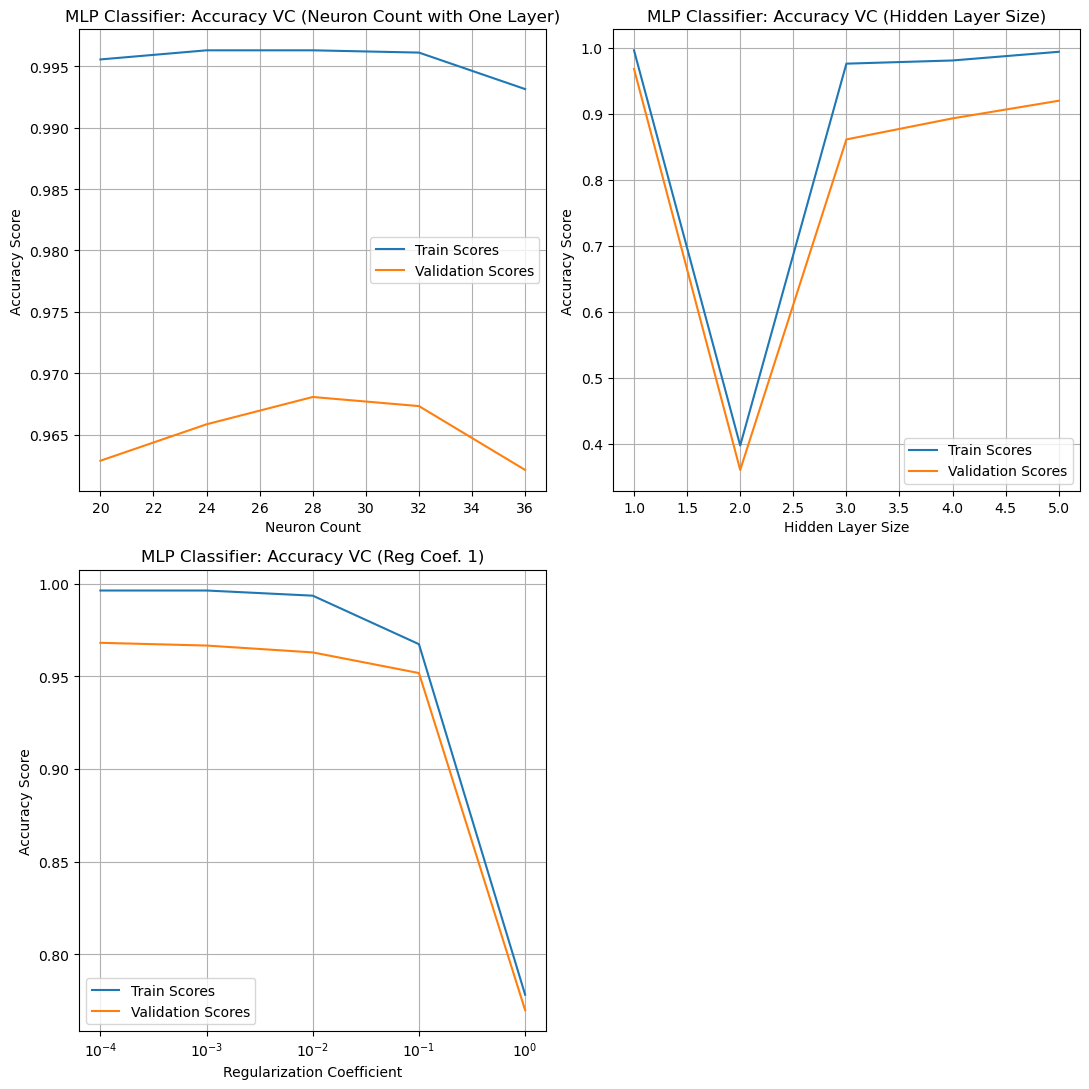

In [17]:
# Create an even number of subplots (e.g., 3 rows, 2 columns for 5 plots)
fig, axs = plt.subplots(2, 2, figsize=(11,11))

# Flatten the axes array for easier iteration
axs = axs.flatten()
count = 0
for key, value in vc_dict.items():
    if value[2] == True:
        axs[count].semilogx(value[1], value[3][0], label=value[4][0])
        axs[count].semilogx(value[1], value[3][1], label=value[4][1])
    else:
        axs[count].plot(value[1], value[2][0], label=value[3][0])
        axs[count].plot(value[1], value[2][1], label=value[3][1])
    axs[count].set_xlabel(value[0][0])
    axs[count].set_ylabel(value[0][1])
    axs[count].set_title(key)
    axs[count].grid()
    axs[count].minorticks_off()
    axs[count].legend()
    count += 1

fig.delaxes(axs[count]) 
plt.tight_layout()
plt.show()

<h3><strong><u>Cross-Validation Test</u></strong></h3>

In [18]:
pipeline = Pipeline(
    [
        ("clf", MLPClassifier(max_iter=5000, random_state=1)),
    ]
)

cv_params = {
    'clf__hidden_layer_sizes': [(24,), (26,), (28,), (30,), (32,), (34,)]
}
grid_search = GridSearchCV(pipeline, cv_params, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
mlp_classifier = grid_search.best_estimator_
print(grid_search.best_params_)

def mlp_digit_classifier():
    return mlp_classifier


{'clf__hidden_layer_sizes': (28,)}


<h4><strong><u>Findings From 'Model Selection' Section</u></strong></h4>
All validation curve tests yielded positive results. It seems the a low neuron count with a single layer and low regularization is the best as suggested by these tests.

<h2><strong><u>Model Evaluation</u></strong></h2>

<h3><strong><u>Learning Curve</u></strong></h4>

In [19]:
for key, value in clf_metrics.items():
    mlp_train_sizes, mlp_train_scores, mlp_validation_scores = learning_curve(
        mlp_classifier,
        X_train,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    mlp_train_scores_mean = np.mean(mlp_train_scores, axis=1)
    mlp_train_scores_std = np.std(mlp_train_scores, axis=1)
    mlp_validation_scores_mean = np.mean(mlp_validation_scores, axis=1)
    mlp_validation_scores_std = np.std(mlp_validation_scores, axis=1)

        # Calculate spread of data around the mean
    mlp_train_range_minus = mlp_train_scores_mean - mlp_train_scores_std
    mlp_train_range_plus = mlp_train_scores_mean + mlp_train_scores_std
    mlp_validation_range_minus = mlp_validation_scores_mean - mlp_validation_scores_std
    mlp_validation_range_plus = mlp_validation_scores_mean + mlp_validation_scores_std

    lc_dict[key] = [[mlp_train_scores_mean, mlp_validation_scores_mean],
                    [mlp_train_range_minus, mlp_train_range_plus], 
                    [mlp_validation_range_minus, mlp_validation_range_plus], 
                    mlp_train_sizes]

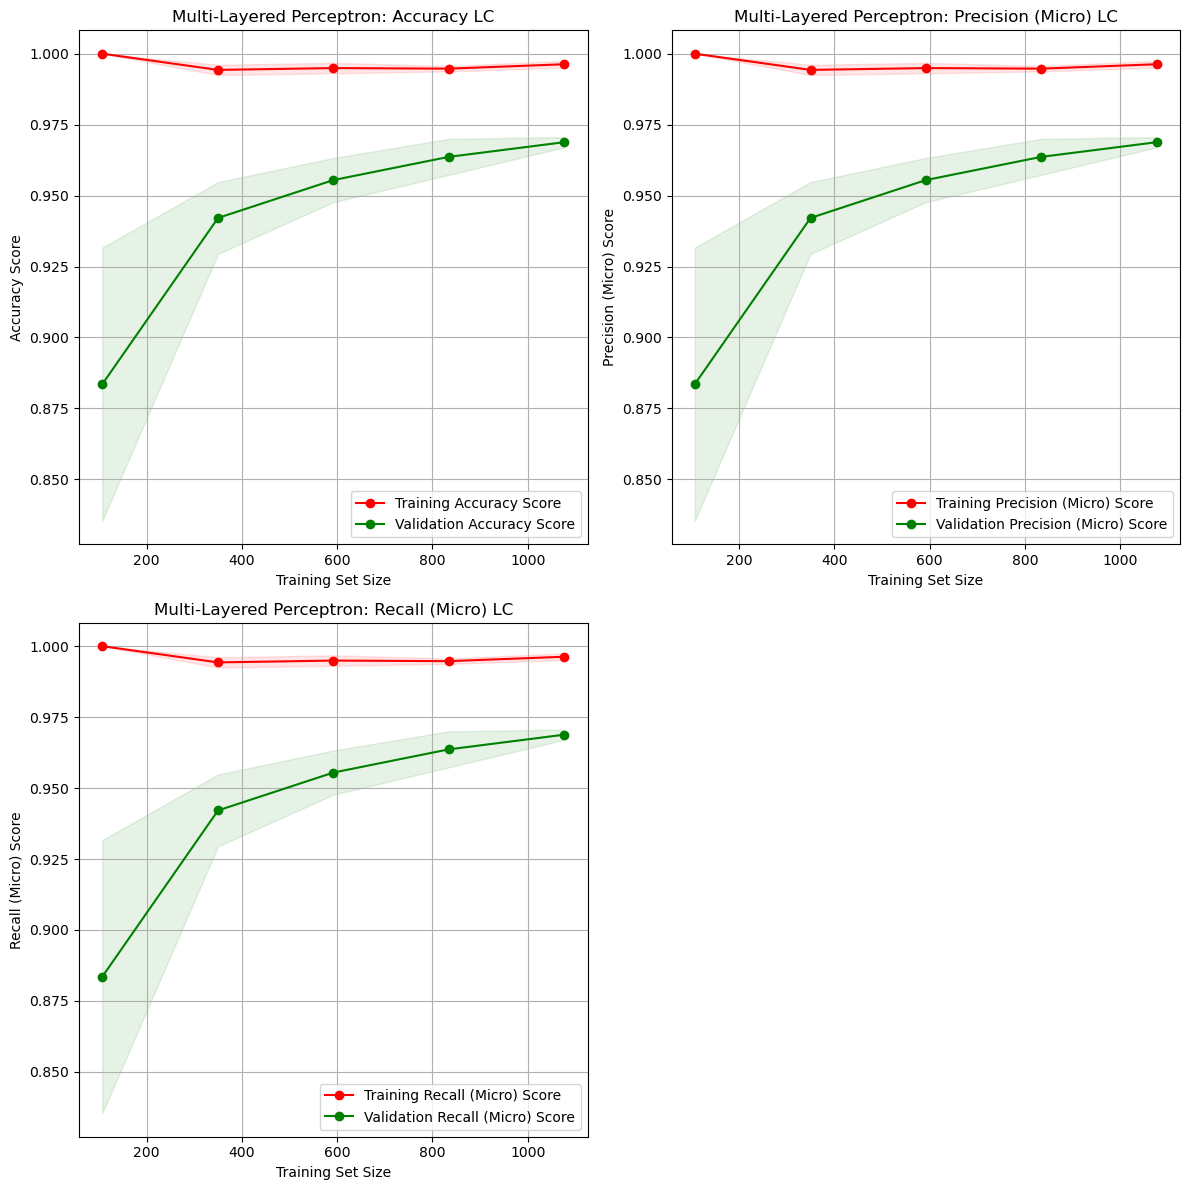

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Flatten the axes array for easier iteration
axs = axs.flatten()
count = 0
for key, value in lc_dict.items():
    axs[count].set_title(f"Multi-Layered Perceptron: {key} LC")
    axs[count].set_xlabel("Training Set Size")
    axs[count].set_ylabel(f"{key} Score")
    axs[count].grid()

    axs[count].fill_between(value[3], value[1][0], value[1][1], alpha=0.1, color="r")
    axs[count].fill_between(value[3], value[2][0], value[2][1], alpha=0.1, color="g")
    axs[count].plot(value[3], value[0][0], 'o-', color="r", label=f"Training {key} Score")
    axs[count].plot(value[3], value[0][1], 'o-', color="g", label=f"Validation {key} Score")
    axs[count].legend()
    count += 1
    
fig.delaxes(axs[count]) 

plt.tight_layout()
plt.show()

<h3><strong><u>Evaluation Metrics</u></strong></h3>

In [21]:
for key, value in clf_metrics.items():
    nb_training_values = cross_val_score(mlp_classifier, X_train, y=y_train, scoring=value, cv=5)
    np_nb_training_values = np.array(nb_training_values)
    average = np.mean(np_nb_training_values)
    stDev = np.std(np_nb_training_values)
    cvs_dict[key] = [nb_training_values, [average, stDev]]

In [22]:
for key, value in cvs_dict.items():
    print(f"{key}")
    print("CV Training Scores: ", value[0])
    print(f"Training Average and Standard Error: ", "{:.2f}%".format(value[1][0].round(2)), "\u00B1", "{:.2f}%".format(value[1][1].round(4)*100), "\n")

Accuracy
CV Training Scores:  [0.97037037 0.96666667 0.96282528 0.97026022 0.97026022]
Training Average and Standard Error:  0.97% ± 0.30% 

Precision (Micro)
CV Training Scores:  [0.97037037 0.96666667 0.96282528 0.97026022 0.97026022]
Training Average and Standard Error:  0.97% ± 0.30% 

Recall (Micro)
CV Training Scores:  [0.97037037 0.96666667 0.96282528 0.97026022 0.97026022]
Training Average and Standard Error:  0.97% ± 0.30% 



Text(0.5, 1.0, 'Multi-Layered Perceptron: Confusion Matrix (Evaluation)')

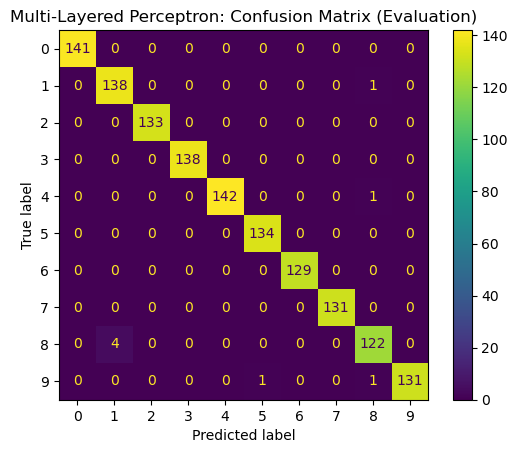

In [24]:
#Training Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(mlp_classifier, X_train, y_train)
disp.ax_.set_title("Multi-Layered Perceptron: Confusion Matrix (Evaluation)")

<h4><strong><u>Findings From 'Model Evaluation' Phase</u></strong></h4>
In the evaluation of my selected Multi-Layered Perceptron model, I found positive results for all evaluation methods.